In [1]:
import gym
from collections import deque, namedtuple
import random
import numpy as np
from tqdm.notebook import tqdm 
import time

import pandas as pd
import torch
import torch
from torch import nn
from torch.optim import SGD, Adam
from torch.distributions.categorical import Categorical

from dataclasses import dataclass, field

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
matplotlib.rcParams['figure.figsize'] = (20, 10)

from abc import ABC, abstractmethod
from typing import List, Dict, Tuple, Any, Optional, Callable

import toolz

In [2]:
class Identity(nn.Module):
    def forward(self, x): return x

class Argmax(nn.Module):
    def forward(self, x): return x.argmax()

def create_model(input_size: int, output_size: int, hidden_layers=[16], activate_every=2, output_layer=Identity):
    layers = [nn.Linear(in_shape, out_shape) for (in_shape, out_shape) in toolz.sliding_window(2, hidden_layers)]
    layers = [*toolz.concat([*ls, nn.ReLU()] for ls in toolz.partition(activate_every, layers))]
    layers = [nn.ReLU(), *layers]
    return nn.Sequential(
        nn.Linear(input_size, hidden_layers[0]),
        *layers,
        nn.Linear(hidden_layers[-1], output_size),
        output_layer(),
    )

In [3]:
@dataclass
class Model:
    input_size     : int
    output_size    : int
    hidden_layers  : List[int]
    activate_every : int
    model          : nn.Module                  
    create_model_fn: Callable[[Any], nn.Module] 
    output_layer   : nn.Module                  = field(default_factory=Identity)
    
    @classmethod
    def from_input_size(
        cls, 
        input_size: int, 
        output_size: int, 
        hidden_layers: List[int]=[8], 
        activate_every: int=2, 
        output_layer: 
        nn.Module=Identity
    ):
        create_model_fn = lambda: create_model(
            input_size=input_size, 
            output_size=output_size, 
            hidden_layers=hidden_layers,
            activate_every=activate_every,
            output_layer=output_layer,
        )
        return cls(
            input_size=input_size, 
            output_size=output_size, 
            hidden_layers=hidden_layers,
            activate_every=activate_every,
            output_layer=output_layer,
            create_model_fn=create_model_fn,
            model=create_model_fn(),
        )
    
    def __post_init__(self):
        self.create_model_fn = lambda: create_model(
            input_size=self.input_size, 
            output_size=self.output_size, 
            hidden_layers=self.hidden_layers,
            activate_every=self.activate_every,
            output_layer = self.output_layer
        )
        
        self.model = self.create_model_fn()
        
    def __call__(self, x): return self.model(x)
    def get_action(self, x): return self(x).item()
    
    def jiggle(self, mu=0, sigma=1.0):
        state_dict: List[nn.Parameter] = self.model.state_dict()
        for p in state_dict:
            p._add(mu + torch.randn(*p.shape) * sigma)
        
        model: nn.Module = self.create_model_fn()
        model.load_state_dict(state_dict)
        
        return Model(
            input_size      = self.input_size, 
            output_size     = self.output_size, 
            hidden_layers   = self.hidden_layers,
            activate_every  = self.activate_every,
            output_layer    = self.output_layer,
            create_model_fn = self.create_model_fn,
            model           = model,
        )
    
    def step(self, env: gym.Env, fps: Optional[int]=None) -> Dict[str, Any]:
        state = env.reset()
        done = False
        ep_len = 0
        total_reward = 0
        
        while not done:
            if fps: env.render()
            action = self.get_action(torch.as_tensor(state, dtype=torch.float32))
            state, reward, done, _ = env.step(action)
            if fps: time.sleep(1/fps)
            
            total_reward += reward
            ep_len += 1
            
        if fps: env.close()
        return { 
            'EpisodeLength': ep_len, 
            'Reward': total_reward,
        }

ModelScore = Tuple[Model, float]
class SelectionPolicy(ABC):
    @abstractmethod
    def select(xs: List[ModelScore]): raise NotImplementedError()
    
class CrossoverPolicy(ABC):
    @abstractmethod
    def crossover(xs: List[Model], lr: float): raise NotImplementedError()

class LRPolicy(ABC):
    @abstractmethod
    def update(self, lr: float): raise NotImplementedError()
    
class ConstLR(LRPolicy):
    def update(self, lr: float): return lr
    
class TopHalf(SelectionPolicy):
    def select(xs: List[ModelScore]):
        scores = sorted(xs, key=lambda s: s[1])
        return scores[:scores // 2]
        
@dataclass
class Jiggle(CrossoverPolicy):
    keep: bool
    def crossover(models: List[Model], lr: float): 
        if keep:
            ms = [[model.jiggle(mu=0., std=lr), model.jiggle(mu=0., std=lr)] for m in models]
        else:
            ms = [[model, model.jiggle(mu=0., std=lr)] for m in models] 
        return [m for mm in ms for m in mm] # Flatten list
        

In [4]:
@dataclass
class Solver:
    population      : List[Model]
    env             : gym.Env
    lr_policy       : LRPolicy        = field(default_factory=ConstLR)
    selection_policy: SelectionPolicy = field(default_factory=TopHalf)
    crossover_policy: CrossoverPolicy = field(default_factory=lambda: Jiggle(keep=True))
    env_name        : str             = 'CartPole-v1'
    population_size : int             = 50
    lr              : float           = 0.05
    
    @classmethod
    def from_params(
        cls, 
        env_name: str        = 'CartPole-v1', 
        population_size: int = 50,
        lr: float            = 0.05,
        **kwargs
    ):
        env = gym.make(env_name)
        input_size = env.observation_space.shape[0]
        
        
        action_space = env.action_space
        if isinstance(action_space, gym.spaces.Box):
            output_size = action_space.shape[0]
            output_layer = Identity
        elif isinstance(action_space, gym.spaces.Discrete):
            output_size = action_space.n
            output_layer = Argmax       
        else: raise ValueError(f'Unkown action space for env {env_name}')
        
        population = [Model.from_input_size(
            input_size=input_size, 
            output_size=output_size,
            output_layer=output_layer,
        ) for _ in range(population_size)]
        
        return cls(
            population=population,
            env=env,
            env_name=env_name,
            population_size=population_size,
            lr=lr,
            **kwargs
        )
        
    def step(self, step: int):
        results = []
        for i, model in enumerate(self.population):
            result = model.step(env=self.env)
            result['step'] = step
            result['model'] = i
            results.append(result)
        
        return results
    
    def train(self, steps: int):
        results = []
        for step in range(steps):
            result = self.step(step)
            results.extend(result)
            
        return pd.DataFrame(results)

In [5]:
solver = Solver.from_params()

In [12]:
df = solver.train(10).sort_values('Reward', ascending=False)
df.head(15)

,EpisodeLength,Reward,step,model
94,91,91.0,1,44
469,77,77.0,9,19
369,71,71.0,7,19
232,69,69.0,4,32
119,66,66.0,2,19
359,65,65.0,7,9
432,60,60.0,8,32
19,55,55.0,0,19
382,54,54.0,7,32
282,53,53.0,5,32


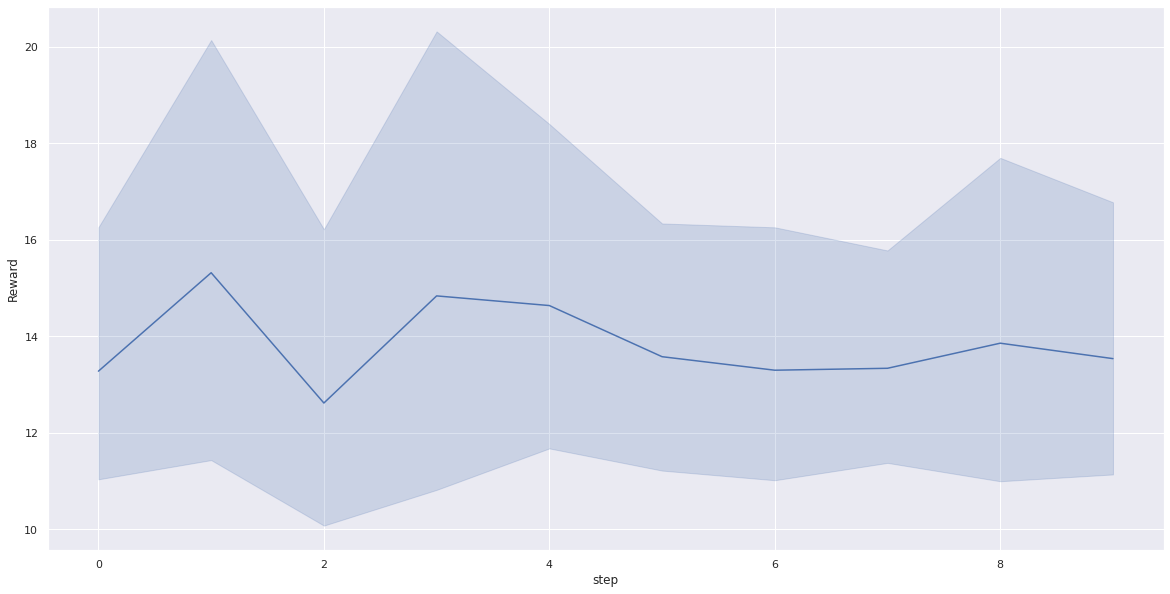

In [10]:
_ = sns.lineplot(data=df, x='step', y='Reward')

In [18]:
solver.population[44].step(env=solver.env, fps=30)

{'EpisodeLength': 40, 'Reward': 40.0}